Make sure you have the below packages downladed (through pip install)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from census import Census
from us import states

Census code was easy to get - just sign up for it with Lehigh University and your lehigh email. The one below is mine (Anna's). 

In [2]:
with open('census_token.txt') as f:
    c = Census(f.read())

In [3]:
# Obtain Census variables from the 2019 ACS at the tract level for the Commonwealth of Virginia (FIPS code: 51)
# C17002_001E: count of ratio of income to poverty in the past 12 months (total)
# C17002_002E: count of ratio of income to poverty in the past 12 months (< 0.50)
# C17002_003E: count of ratio of income to poverty in the past 12 months (0.50 - 0.99)
# B01003_001E: total population
# Sources: https://api.census.gov/data/2019/acs/acs5/variables.html; https://pypi.org/project/census/
va_census = c.acs5.state_county_tract(fields = ('NAME', 'C17002_001E', 'C17002_002E', 'C17002_003E', 'B01003_001E'),
                                      state_fips = states.VA.fips,
                                      county_fips = "*",
                                      tract = "*",
                                      year = 2020)

In [4]:
# Create a dataframe from the census data
va_df = pd.DataFrame(va_census)

# Show the dataframe
print(va_df.head(2))
print('Shape: ', va_df.shape)

                                           NAME  C17002_001E  C17002_002E  \
0  Census Tract 2014, Alexandria city, Virginia       4286.0         56.0   
1  Census Tract 2015, Alexandria city, Virginia       3867.0        110.0   

   C17002_003E  B01003_001E state county   tract  
0         55.0       4286.0    51    510  201400  
1         39.0       4141.0    51    510  201500  
Shape:  (2198, 8)


In [5]:
# Access shapefile of Virginia census tracts
va_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_51_tract.zip")

# Reproject shapefile to UTM Zone 17N
# https://spatialreference.org/ref/epsg/wgs-84-utm-zone-17n/
va_tract = va_tract.to_crs(epsg = 32617)

# Print GeoDataFrame of shapefile
print(va_tract.head(2))
print('Shape: ', va_tract.shape)

# Check shapefile projection
print("\nThe shapefile projection is: {}".format(va_tract.crs))

  STATEFP COUNTYFP TRACTCE        GEOID    NAME             NAMELSAD  MTFCC  \
0      51      700  032132  51700032132  321.32  Census Tract 321.32  G5020   
1      51      700  032226  51700032226  322.26  Census Tract 322.26  G5020   

  FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  2552457       0  +37.1475176  -076.5212499   
1        S  3478916  165945  +37.1625163  -076.5527816   

                                            geometry  
0  POLYGON ((897173.396 4119897.287, 897174.015 4...  
1  POLYGON ((893469.801 4123469.592, 893541.960 4...  
Shape:  (1907, 13)

The shapefile projection is: epsg:32617


In [6]:
# Combine state, county, and tract columns together to create a new string and assign to new column
va_df["GEOID"] = va_df["state"] + va_df["county"] + va_df["tract"]

In [7]:
# Print head of dataframe
va_df.head(2)

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,state,county,tract,GEOID
0,"Census Tract 2014, Alexandria city, Virginia",4286.0,56.0,55.0,4286.0,51,510,201400,51510201400
1,"Census Tract 2015, Alexandria city, Virginia",3867.0,110.0,39.0,4141.0,51,510,201500,51510201500


In [8]:
# Remove columns
va_df = va_df.drop(columns = ["state", "county", "tract"])

# Show updated dataframe
va_df.head(2)

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,GEOID
0,"Census Tract 2014, Alexandria city, Virginia",4286.0,56.0,55.0,4286.0,51510201400
1,"Census Tract 2015, Alexandria city, Virginia",3867.0,110.0,39.0,4141.0,51510201500


In [9]:
# Check column data types for census data
print("Column data types for census data:\n{}".format(va_df.dtypes))

# Check column data types for census shapefile
print("\nColumn data types for census shapefile:\n{}".format(va_tract.dtypes))

# Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas

Column data types for census data:
NAME            object
C17002_001E    float64
C17002_002E    float64
C17002_003E    float64
B01003_001E    float64
GEOID           object
dtype: object

Column data types for census shapefile:
STATEFP       object
COUNTYFP      object
TRACTCE       object
GEOID         object
NAME          object
NAMELSAD      object
MTFCC         object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object


In [10]:
# Join the attributes of the dataframes together
# Source: https://geopandas.org/docs/user_guide/mergingdata.html
va_merge = va_tract.merge(va_df, on = "GEOID")

# Show result
print(va_merge.head(2))
print('Shape: ', va_merge.shape)

  STATEFP COUNTYFP TRACTCE        GEOID  NAME_x             NAMELSAD  MTFCC  \
0      51      700  032132  51700032132  321.32  Census Tract 321.32  G5020   
1      51      700  032226  51700032226  322.26  Census Tract 322.26  G5020   

  FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  2552457       0  +37.1475176  -076.5212499   
1        S  3478916  165945  +37.1625163  -076.5527816   

                                            geometry  \
0  POLYGON ((897173.396 4119897.287, 897174.015 4...   
1  POLYGON ((893469.801 4123469.592, 893541.960 4...   

                                             NAME_y  C17002_001E  C17002_002E  \
0  Census Tract 321.32, Newport News city, Virginia       4400.0        180.0   
1  Census Tract 322.26, Newport News city, Virginia       3811.0        304.0   

   C17002_003E  B01003_001E  
0        163.0       4400.0  
1        432.0       3823.0  
Shape:  (1638, 18)


In [11]:
# Create new dataframe from select columns
va_poverty_tract = va_merge[["STATEFP", "COUNTYFP", "TRACTCE", "GEOID", "geometry", "C17002_001E", "C17002_002E", "C17002_003E", "B01003_001E"]]

# Show dataframe
print(va_poverty_tract.head(2))
print('Shape: ', va_poverty_tract.shape)

  STATEFP COUNTYFP TRACTCE        GEOID  \
0      51      700  032132  51700032132   
1      51      700  032226  51700032226   

                                            geometry  C17002_001E  \
0  POLYGON ((897173.396 4119897.287, 897174.015 4...       4400.0   
1  POLYGON ((893469.801 4123469.592, 893541.960 4...       3811.0   

   C17002_002E  C17002_003E  B01003_001E  
0        180.0        163.0       4400.0  
1        304.0        432.0       3823.0  
Shape:  (1638, 9)


In [12]:
# Dissolve and group the census tracts within each county and aggregate all the values together
# Source: https://geopandas.org/docs/user_guide/aggregation_with_dissolve.html
va_poverty_county = va_poverty_tract.dissolve(by = 'COUNTYFP', aggfunc = 'sum')

# Show dataframe
print(va_poverty_county.head(2))
print('Shape: ', va_poverty_county.shape)

                                                   geometry  C17002_001E  \
COUNTYFP                                                                   
001       POLYGON ((969136.754 4184974.080, 969149.944 4...      17032.0   
003       POLYGON ((734957.170 4207640.282, 734931.151 4...      59478.0   

          C17002_002E  C17002_003E  B01003_001E  
COUNTYFP                                         
001            1488.0       1794.0      17072.0  
003            2166.0       2487.0      60764.0  
Shape:  (129, 5)


In [13]:
# Get poverty rate and store values in new column
va_poverty_county["Poverty_Rate"] = (va_poverty_county["C17002_002E"] + va_poverty_county["C17002_003E"]) / va_poverty_county["B01003_001E"] * 100

# Show dataframe
va_poverty_county.head(2)

,geometry,C17002_001E,C17002_002E,C17002_003E,B01003_001E,Poverty_Rate
COUNTYFP,,,,,,
001,"POLYGON ((969136.754 4184974.080, 969149.944 4...",17032.0,1488.0,1794.0,17072.0,19.224461
003,"POLYGON ((734957.170 4207640.282, 734931.151 4...",59478.0,2166.0,2487.0,60764.0,7.657495


Text(0.5, 1.0, 'Poverty Rates (%) in Virginia')

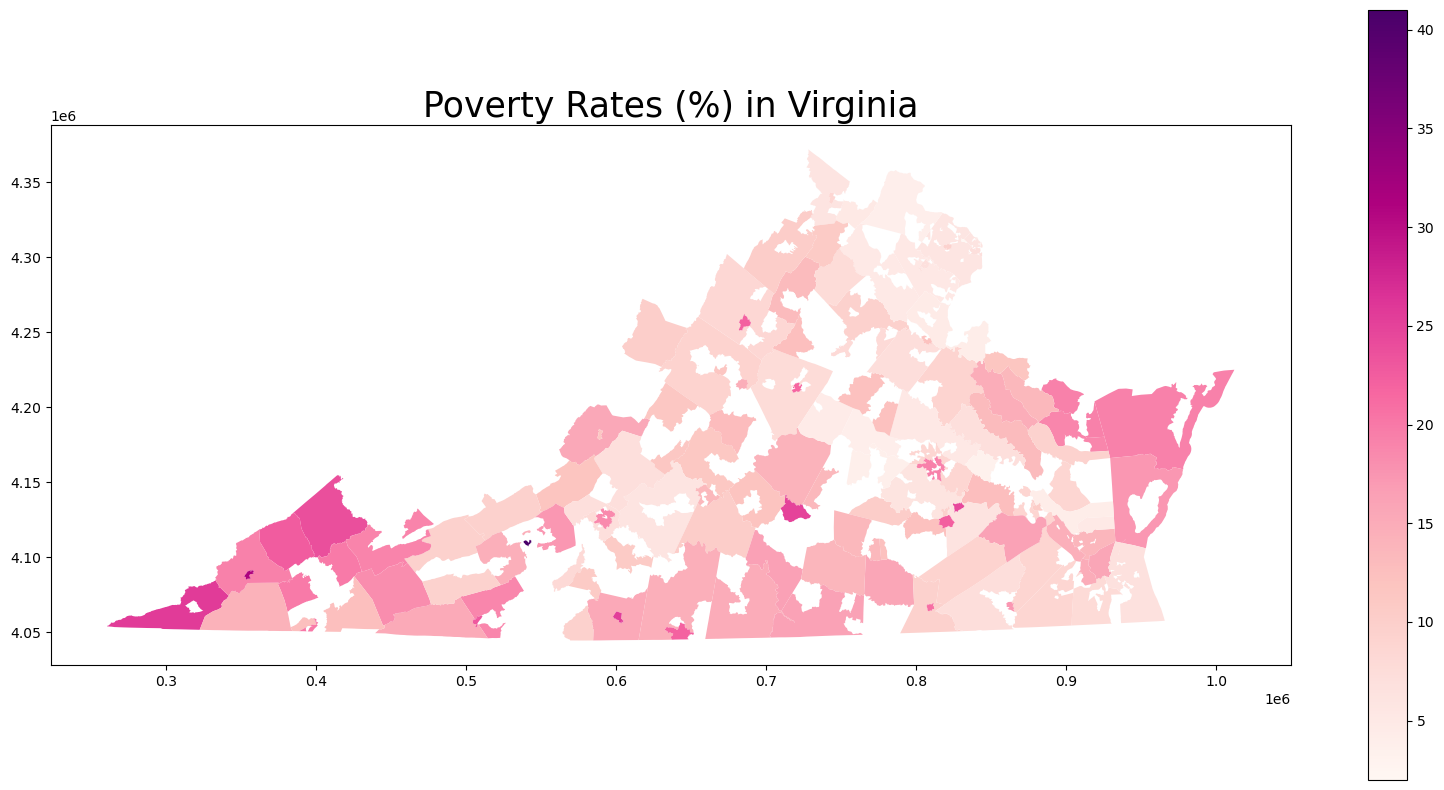

In [14]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

# Plot data
# Source: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html
va_poverty_county.plot(column = "Poverty_Rate",
                       ax = ax,
                       cmap = "RdPu",
                       legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Poverty Rates (%) in Virginia', fontdict = {'fontsize': '25', 'fontweight' : '3'})